## Dataset: Kaggle NLP with Disaster Tweets
Predict which Tweets are about real disasters and which ones are not
- https://www.kaggle.com/c/nlp-getting-started/overview

Low-level Neural Network implementation on Python with Numpy

In [ ]:
!pip install tokenization
!pip install tweet-preprocessor

In [ ]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import tokenization
from sklearn import preprocessing
import preprocessor as p
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
nltk.download
nltk.download('wordnet')
nltk.download('stopwords')
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.metrics import BinaryAccuracy
import math

%matplotlib inline

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Load dataset
train_set = pd.read_csv('data/train.csv')
test_set = pd.read_csv('data/test.csv')
sample_submission = pd.read_csv('data/sample_submission.csv')

In [ ]:
print(train_set.head(), '\n', 'Train set shape: ', train_set.shape)

   id keyword  ...                                               text target
0   1     NaN  ...  Our Deeds are the Reason of this #earthquake M...      1
1   4     NaN  ...             Forest fire near La Ronge Sask. Canada      1
2   5     NaN  ...  All residents asked to 'shelter in place' are ...      1
3   6     NaN  ...  13,000 people receive #wildfires evacuation or...      1
4   7     NaN  ...  Just got sent this photo from Ruby #Alaska as ...      1

[5 rows x 5 columns] 
 Train set shape:  (7613, 5)


In [ ]:
train_set.drop_duplicates('text', keep = 'last', inplace = True)
print('Train set shape without duplicates: ', train_set.shape)

train_set.reset_index(inplace = True)

Train set shape without duplicates:  (7503, 5)


In [ ]:
print(test_set.head(), '\n', 'test set shape: ', test_set.shape)

   id keyword location                                               text
0   0     NaN      NaN                 Just happened a terrible car crash
1   2     NaN      NaN  Heard about #earthquake is different cities, s...
2   3     NaN      NaN  there is a forest fire at spot pond, geese are...
3   9     NaN      NaN           Apocalypse lighting. #Spokane #wildfires
4  11     NaN      NaN      Typhoon Soudelor kills 28 in China and Taiwan 
 test set shape:  (3263, 4)


In [ ]:
# Encoding labels
label = preprocessing.LabelEncoder()
train_y = label.fit_transform(train_set['target'])

print('Train set shape: ', train_y.shape, train_y.dtype)
print('Disaster tweets on training set: ', np.count_nonzero(train_y == 1))
print('Non-disaster tweets on training set: ', np.count_nonzero(train_y == 0))

Train set shape:  (7503,) int64
Disaster tweets on training set:  3196
Non-disaster tweets on training set:  4307


### Tweets Preprocessing

In [ ]:
# Analyzing unique keywords on original datasets
train_set['keyword'].value_counts()

fatalities               45
armageddon               42
deluge                   42
damage                   41
harm                     41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

In [ ]:
test_set['keyword'].value_counts()

deluged                  23
demolished               22
rubble                   22
annihilation             21
obliteration             21
                         ..
fatalities                5
radiation%20emergency     5
threat                    5
inundation                4
epicentre                 1
Name: keyword, Length: 221, dtype: int64

In [ ]:
unique_keys = set(np.concatenate((test_set['keyword'].unique(), train_set['keyword'].unique())))
len(unique_keys) -1 # Removing nan
# Distribution of unique keys are the same within training and test datasets

221

In [ ]:
# Capturing new keywords with Hashtag Extraction using Regex
def hashtag_extract(tweet):
  """
  Extract hashtag from text strings within individual tweets.
  
  Argument: tweet -- String.
  Returns: hashtag -- List of lowercase strings. Hashtags contained on tweet.
  """
  hashtag = re.findall(r"#(\w+)", tweet)
  hashtag = list(map(str.lower, hashtag))
  return hashtag

train_set['hashtags'] = train_set['text'].apply(hashtag_extract)
train_set.head()

,index,id,keyword,location,text,target,hashtags
0,0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,[earthquake]
1,1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,[]
2,2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,[]
3,3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,[wildfires]
4,4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,"[alaska, wildfires]"


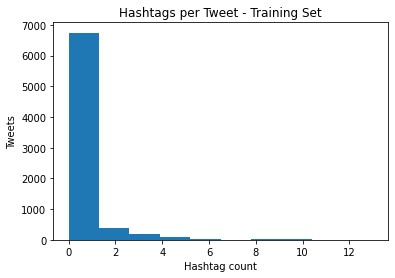

In [ ]:
# Analyzing hashtag counts per tweet
lengths = []
for hashtags in train_set['hashtags']:
  lengths.append(len(hashtags))

plt.hist(lengths)
plt.title('Hashtags per Tweet - Training Set')
plt.xlabel('Hashtag count')
plt.ylabel('Tweets');

In [ ]:
# Capturing Hashtags on test dataset
test_set['hashtags'] = test_set['text'].apply(hashtag_extract)
test_set.head()

,id,keyword,location,text,hashtags
0,0,NaN,NaN,Just happened a terrible car crash,[]
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",[earthquake]
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",[]
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,"[spokane, wildfires]"
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,[]


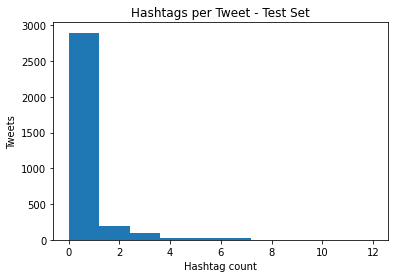

In [ ]:
lengths = []
for hashtags in test_set['hashtags']:
  lengths.append(len(hashtags))

plt.hist(lengths)
plt.title('Hashtags per Tweet - Test Set')
plt.xlabel('Hashtag count')
plt.ylabel('Tweets');

# Distribution of hashtag counts is compatible within test and training datasets

In [ ]:
# Text cleaning - Removing URLs, mentions, etc using tweet-preprocessor package
def tweet_clean(tweet):
  """
  Clean tweet with tweet-preprocessor p.clean() removing unwanted characters,
  user mentions, punctuations and setting to lower case text.

  Argument: tweet -- Ttext string.
  Returns: cleaned_tweet -- Cleaned tweet text string.
  """
  # Remove user mentions, symbols and unwanted characters
  tweet = p.clean(tweet)

  # Remove digits and setting lower case text
  tweet = tweet.replace('\d+', '').lower()

  # Remove punctuations
  cleaned_tweet = re.sub(r'[^\w\s]', '', tweet)

  return cleaned_tweet

train_set['text'] = train_set['text'].apply(tweet_clean)
test_set['text'] = test_set['text'].apply(tweet_clean)

print('First 5 cleaned train_set tweets :\n', train_set['text'].head(), '\n')
print('First 5 cleaned test_set tweets :\n', test_set['text'].head())

First 5 cleaned train_set tweets :
 0    our deeds are the reason of this may allah for...
1                forest fire near la ronge sask canada
2    all residents asked to shelter in place are be...
3       people receive evacuation orders in california
4    just got sent this photo from ruby as smoke fr...
Name: text, dtype: object 

First 5 cleaned test_set tweets :
 0                   just happened a terrible car crash
1    heard about is different cities stay safe ever...
2    there is a forest fire at spot pond geese are ...
3                                  apocalypse lighting
4           typhoon soudelor kills in china and taiwan
Name: text, dtype: object


In [ ]:
# Stemming, Lemmatization and Tokenization using nltk package
def tweet_preprocess(tweet):
  """
  Process tweets with stemming, lemmatization, tokenization, and removing stopwords.
  Stopwords dictionary = English

  Arguments: tweet -- String.
  Returns: processed_tweed -- List of strings with stemmed lemmatized tokenized
  words contained in tweet, without stopwords.
  """
  stemmer = nltk.SnowballStemmer('english')
  lemmatizer = nltk.stem.WordNetLemmatizer()
  tokenizer = TweetTokenizer()
  stop_words = set(stopwords.words('english')) # Create stopwords set

  # Stemming (having -> have)
  tweet = stemmer.stem(tweet)

  # Lemmatization ('dogs' -> 'dog') and 
  # Tokenization ('good muffins cost $10' -> ['good', 'muffins', 'cost', '$', '10'])
  tweet = [lemmatizer.lemmatize(w) for w in tokenizer.tokenize(tweet)]

  # Removing stop words (a, an, our, etc.)
  processed_tweet = []
  for word in tweet:
    if word not in stop_words:
      processed_tweet.append(word)

  return processed_tweet

train_set['text'] = train_set['text'].apply(tweet_preprocess)
test_set['text'] = test_set['text'].apply(tweet_preprocess)

print('First 5 processed train_set tweets :\n', train_set['text'].head(), '\n')
print('First 5 processed test_set tweets :\n', test_set['text'].head())

First 5 processed train_set tweets :
 0           [deed, reason, may, allah, forgive, u, al]
1        [forest, fire, near, la, ronge, sask, canada]
2    [resident, asked, shelter, place, notified, of...
3     [people, receive, evacuation, order, california]
4       [got, sent, photo, ruby, smoke, pours, school]
Name: text, dtype: object 

First 5 processed test_set tweets :
 0                     [happened, terrible, car, crash]
1        [heard, different, city, stay, safe, everyon]
2    [forest, fire, spot, pond, goose, fleeing, acr...
3                                  [apocalypse, light]
4             [typhoon, soudelor, kill, china, taiwan]
Name: text, dtype: object


In [ ]:
# Adding hashtag to tweets
for i, hashtag in enumerate(train_set['hashtags']):
  for hashtag in train_set.loc[i, 'hashtags']:
    train_set.loc[i, 'text'].append(hashtag)

train_set

,index,id,keyword,location,text,target,hashtags
0,0,1,NaN,NaN,"[deed, reason, may, allah, forgive, u, al, ear...",1,[earthquake]
1,1,4,NaN,NaN,"[forest, fire, near, la, ronge, sask, canada]",1,[]
2,2,5,NaN,NaN,"[resident, asked, shelter, place, notified, of...",1,[]
3,3,6,NaN,NaN,"[people, receive, evacuation, order, californi...",1,[wildfires]
4,4,7,NaN,NaN,"[got, sent, photo, ruby, smoke, pours, school,...",1,"[alaska, wildfires]"
...,...,...,...,...,...,...,...
7498,7608,10869,NaN,NaN,"[two, giant, crane, holding, bridge, collapse,...",1,[]
7499,7609,10870,NaN,NaN,"[control, wild, fire, california, even, northe...",1,[]
7500,7610,10871,NaN,NaN,"[m194, 0104, utc, 5km, volcano, hawaii]",1,[]
7501,7611,10872,NaN,NaN,"[police, investigating, ebike, collided, car, ...",1,[]


In [ ]:
# Tokenizing text data into matrix form using Keras text preprocessing
def sequentialize(tweets, max_words = 5000, words_per_element = 50, enforce_words_per_element = False):
  """
  Sequentialize tweets into an (m, x) matrix, where:
  m = number of tweet samples
  x = dimension of individual tweet object, after tokenized

  Arguments:
  tweets -- preprocessed tweets. Each individual element should be contained into a list.
            Use tweet_preprocess() function before sequentialize()
  max_words -- Int. Hyperparameter where only the most common (max_words - 1) will be kept,
            based on word frequency
  words_per_element -- Int. Default = 50. Maximum dimension of individual tweet vectors,
            padded with zeros. Also seen as number of features per training/testing element.
            Automatically set to the maximum number needed per individual tweet, after a
            first sequentialize iteration.
  enforce_words_per_element -- Boolean. Default = False. When 'True', enforces the inputed
            words_per_element value into the final tweet vector.

  Returns:
  sequences_matrix -- Numpy array of shape (m, x).
  """
  # max_words = 5000
  # Hyperparameter: Only the most common (max_words - 1) will be kept, based on word frequency

  global max_len
  max_len = words_per_element
  # max_len = 5
  # Number of words to pad and fit into feature X matrix

  tok = Tokenizer(num_words = max_words)
  X = tweets

  tok.fit_on_texts(X) # Updates internal vocabulary based on list of texts
  sequences = tok.texts_to_sequences(X) # Tokenize word sequences
  sequences_matrix = sequence.pad_sequences(sequences, maxlen = max_len)

  # Checking token counts per tweet
  word_counts = []
  for i in range(0, sequences_matrix.shape[0]):
    word_counts.append(np.count_nonzero(sequences_matrix[i, :]))

  if (max(word_counts) < max_len) and not enforce_words_per_element:
    max_len = max(word_counts)
    sequences_matrix = sequence.pad_sequences(sequences, maxlen = max_len)
    print('max_words_per_element value updated:', max_len)

  global highest_word_token
  highest_word_token = max(list(max(i) for i in sequences_matrix[:, ]))

  print(f'Highest word token: {highest_word_token}')

  return sequences_matrix

sequences_matrix = sequentialize(train_set['text'], max_words = 10000)

print(sequences_matrix.shape, sequences_matrix.dtype)
print(sequences_matrix[0, :])
print(sequences_matrix[0, :].shape)

max_words_per_element value updated: 23
Highest word token: 9999
(7503, 23) int32
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 5897  417   69 1665 3978    9  622  182]
(23,)


Maximum token count per tweet with 5000 words tokenization: 23 



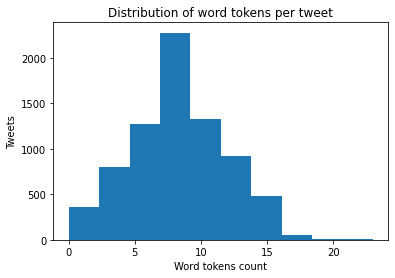

In [ ]:
# Analyzing word counts after tokenizing into matrices
word_counts = []
for i in range(0, sequences_matrix.shape[0]):
  word_counts.append(np.count_nonzero(sequences_matrix[i, :]))

print(f'Maximum token count per tweet with {max_words} words tokenization:', max(word_counts), '\n')

plt.hist(word_counts)
plt.title('Distribution of word tokens per tweet')
plt.xlabel('Word tokens count')
plt.ylabel('Tweets');

In [ ]:
# Defining train_X and train_Y vectors
train_X = (sequences_matrix/highest_word_token).T # Transpose of scaled sequences_matrix with shape (x_i, m)
train_Y = train_set['target'].values.reshape((train_set['target'].shape[0], -1)).T # Transpose of Y vector flattened from train_set['target']

print('First element (example) of training set: ', train_X[:, 0], '\n')
print('Training set train_X shape: ', train_X.shape, '\n-------------------\n')
print('Y_1: ', train_Y[:, 0], '\n')
print('Training set train_Y shape: ', train_Y.shape)

First element (example) of training set:  [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.58975898 0.04170417 0.00690069
 0.16651665 0.39783978 0.00090009 0.06220622 0.01820182] 

Training set train_X shape:  (23, 7503) 
-------------------

Y_1:  [1] 

Training set train_Y shape:  (1, 7503)


### Neural Network
Low-level neural network implementation with Numpy.

Code reference from deeplearning.ai Course-2: Improving Deep Neural Networks.

In [ ]:
# Sigmoid and ReLU activation functions
def sigmoid(x):
    """
    Compute the sigmoid of x

    Arguments:
    x -- A scalar or numpy array of any size.
    Return:
    s -- sigmoid(x)
    """
    s = 1/(1+np.exp(-x))
    return s

def relu(x):
    """
    Compute the relu of x

    Arguments:
    x -- A scalar or numpy array of any size.
    Return:
    s -- relu(x)
    """
    s = np.maximum(0,x)
    return s

In [ ]:
# Parameters initialization
def initialize_parameters(layer_dims):
    """
    Arguments:
    layer_dims -- python array (list) containing the dimensions of each layer in our network
    
    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    W1 -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                    b1 -- bias vector of shape (layer_dims[l], 1)
                    Wl -- weight matrix of shape (layer_dims[l-1], layer_dims[l])
                    bl -- bias vector of shape (1, layer_dims[l])
                    
    Example: the layer_dims for the a 3-layer Neural Network with:
      - 2 input features
      - 3 layers in total, with 2 hidden layers and 1 input layer
      - 2 hidden units on layer 1
      - 1 hidden unit on layer 2
      Would be [2,2,1]
    This means W1's shape is (2,2), b1 is (1,2), W2 is (2,1) and b2 is (1,1).
    """
    
    np.random.seed(3)
    parameters = {}
    L = len(layer_dims) # number of layers in the network

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1])*  np.sqrt(2 / layer_dims[l-1])
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
        assert parameters['W' + str(l)].shape[0] == layer_dims[l], layer_dims[l-1]
        assert parameters['W' + str(l)].shape[0] == layer_dims[l], 1
        
    return parameters

In [ ]:
# Cross-entropy cost function
def compute_cost(a3, Y):
    
    """
    Implement the cost function
    
    Arguments:
    a3 -- post-activation, output of forward propagation
    Y -- "true" labels vector, same shape as a3
    
    Returns:
    cost - value of the cost function without dividing by number of training examples
    
    Note: 
    This is used with mini-batches, 
    so we'll first accumulate costs over an entire epoch 
    and then divide by the m training examples
    """
    
    logprobs = np.multiply(-np.log(a3),Y) + np.multiply(-np.log(1 - a3), 1 - Y)
    cost_total =  np.sum(logprobs)
    
    return cost_total

In [ ]:
# Forward Propagation
def forward_propagation(X, parameters):
    """
    Implements the forward propagation (and computes the loss) presented in Figure 2.
    
    Arguments:
    X -- input dataset, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3":
                    W1 -- weight matrix of shape ()
                    b1 -- bias vector of shape ()
                    W2 -- weight matrix of shape ()
                    b2 -- bias vector of shape ()
                    W3 -- weight matrix of shape ()
                    b3 -- bias vector of shape ()
    
    Returns:
    loss -- the loss function (vanilla logistic loss)
    """
    
    # retrieve parameters
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    W3 = parameters["W3"]
    b3 = parameters["b3"]
    
    # LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID
    z1 = np.dot(W1, X) + b1
    a1 = relu(z1)
    z2 = np.dot(W2, a1) + b2
    a2 = relu(z2)
    z3 = np.dot(W3, a2) + b3
    a3 = sigmoid(z3)
    
    cache = (z1, a1, W1, b1, z2, a2, W2, b2, z3, a3, W3, b3)
    
    return a3, cache

In [ ]:
# Backward Propagation
def backward_propagation(X, Y, cache):
    """
    Implement the backward propagation presented in figure 2.
    
    Arguments:
    X -- input dataset, of shape (input size, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat)
    cache -- cache output from forward_propagation()
    
    Returns:
    gradients -- A dictionary with the gradients with respect to each parameter, activation and pre-activation variables
    """
    m = X.shape[1]
    (z1, a1, W1, b1, z2, a2, W2, b2, z3, a3, W3, b3) = cache
    
    dz3 = 1./m * (a3 - Y)
    dW3 = np.dot(dz3, a2.T)
    db3 = np.sum(dz3, axis=1, keepdims = True)
    
    da2 = np.dot(W3.T, dz3)
    dz2 = np.multiply(da2, np.int64(a2 > 0))
    dW2 = np.dot(dz2, a1.T)
    db2 = np.sum(dz2, axis=1, keepdims = True)
    
    da1 = np.dot(W2.T, dz2)
    dz1 = np.multiply(da1, np.int64(a1 > 0))
    dW1 = np.dot(dz1, X.T)
    db1 = np.sum(dz1, axis=1, keepdims = True)
    
    gradients = {"dz3": dz3, "dW3": dW3, "db3": db3,
                 "da2": da2, "dz2": dz2, "dW2": dW2, "db2": db2,
                 "da1": da1, "dz1": dz1, "dW1": dW1, "db1": db1}
    
    return gradients

In [ ]:
# Predict
def predict(X, y, parameters):
    """
    This function is used to predict the results of a  n-layer neural network.
    
    Arguments:
    X -- data set of examples you would like to label
    parameters -- parameters of the trained model
    
    Returns:
    p -- predictions for the given dataset X
    """
    
    m = X.shape[1]
    p = np.zeros((1,m), dtype = np.int)
    
    # Forward propagation
    a3, caches = forward_propagation(X, parameters)
    
    # convert probas to 0/1 predictions
    for i in range(0, a3.shape[1]):
        if a3[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0

    # print results

    #print ("predictions: " + str(p[0,:]))
    #print ("true labels: " + str(y[0,:]))
    print("Accuracy: "  + str(np.mean((p[0,:] == y[0,:]))))
    
    return p

In [ ]:
# Random Mini-Batches
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (1, number of examples)
    mini_batch_size -- size of the mini-batches, integer
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    np.random.seed(seed)
    m = X.shape[1]       # number of training examples
    mini_batches = []
        
    # Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((1, m))
    
    inc = mini_batch_size

    # Partition (shuffled_X, shuffled_Y).
    # Cases with a complete mini batch size only i.e each of 64 examples.
    num_complete_minibatches = math.floor(m / mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, (k*inc) : ((k+1)*inc)]
        mini_batch_Y = shuffled_Y[:, (k*inc) : ((k+1)*inc)]
        
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # For handling the end case (last mini-batch < mini_batch_size i.e less than 64)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches*inc : m]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches*inc : m]
        
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [ ]:
# Adam optimization algorithm (RMSprop + Momentum)
# Initialization
def initialize_adam(parameters) :
    """
    Initializes v and s as two python dictionaries with:
                - keys: "dW1", "db1", ..., "dWL", "dbL" 
                - values: numpy arrays of zeros of the same shape as the corresponding gradients/parameters.
    
    Arguments:
    parameters -- python dictionary containing your parameters.
                    parameters["W" + str(l)] = Wl
                    parameters["b" + str(l)] = bl
    
    Returns: 
    v -- python dictionary that will contain the exponentially weighted average of the gradient. Initialized with zeros.
                    v["dW" + str(l)] = ...
                    v["db" + str(l)] = ...
    s -- python dictionary that will contain the exponentially weighted average of the squared gradient. Initialized with zeros.
                    s["dW" + str(l)] = ...
                    s["db" + str(l)] = ...

    """
    
    L = len(parameters) // 2 # number of layers in the neural networks
    v = {}
    s = {}
    
    # Initialize v, s. Input: "parameters". Outputs: "v, s".
    for l in range(1, L + 1):
        v["dW" + str(l)] = np.zeros(parameters["W" + str(l)].shape)
        v["db" + str(l)] = np.zeros(parameters["b" + str(l)].shape)
        s["dW" + str(l)] = np.zeros(parameters["W" + str(l)].shape)
        s["db" + str(l)] = np.zeros(parameters["b" + str(l)].shape)
        
    return v, s

# Update parameters with Adam
def update_parameters_with_adam(parameters, grads, v, s, t, learning_rate = 0.01,
                                beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8):
    """
    Update parameters using Adam
    
    Arguments:
    parameters -- python dictionary containing your parameters:
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl
    grads -- python dictionary containing your gradients for each parameters:
                    grads['dW' + str(l)] = dWl
                    grads['db' + str(l)] = dbl
    v -- Adam variable, moving average of the first gradient, python dictionary
    s -- Adam variable, moving average of the squared gradient, python dictionary
    t -- Adam variable, counts the number of taken steps
    learning_rate -- the learning rate, scalar.
    beta1 -- Exponential decay hyperparameter for the first moment estimates 
    beta2 -- Exponential decay hyperparameter for the second moment estimates 
    epsilon -- hyperparameter preventing division by zero in Adam updates

    Returns:
    parameters -- python dictionary containing your updated parameters 
    v -- Adam variable, moving average of the first gradient, python dictionary
    s -- Adam variable, moving average of the squared gradient, python dictionary
    """
    
    L = len(parameters) // 2                 # number of layers in the neural networks
    v_corrected = {}                         # Initializing first moment estimate, python dictionary
    s_corrected = {}                         # Initializing second moment estimate, python dictionary
    
    # Perform Adam update on all parameters
    for l in range(1, L + 1):
        # Moving average of the gradients. Inputs: "v, grads, beta1". Output: "v".
        v["dW" + str(l)] = beta1*v["dW" + str(l)] + (1-beta1)*grads["dW" + str(l)]
        v["db" + str(l)] = beta1*v["db" + str(l)] + (1-beta1)*grads["db" + str(l)]

        # Compute bias-corrected first moment estimate. Inputs: "v, beta1, t". Output: "v_corrected".
        v_corrected["dW" + str(l)] = v["dW" + str(l)]/(1-beta1**t)
        v_corrected["db" + str(l)] = v["db" + str(l)]/(1-beta1**t)

        # Moving average of the squared gradients. Inputs: "s, grads, beta2". Output: "s".
        s["dW" + str(l)] = beta2*s["dW" + str(l)] + (1-beta2)*grads["dW" + str(l)]**2
        s["db" + str(l)] = beta2*s["db" + str(l)] + (1-beta2)*grads["db" + str(l)]**2

        # Compute bias-corrected second raw moment estimate. Inputs: "s, beta2, t". Output: "s_corrected".
        s_corrected["dW" + str(l)] = s["dW" + str(l)]/(1-beta2**t)
        s_corrected["db" + str(l)] = s["db" + str(l)]/(1-beta2**t)

        # Update parameters. Inputs: "parameters, learning_rate, v_corrected, s_corrected, epsilon". Output: "parameters".
        parameters["W" + str(l)] = parameters["W" + str(l)] - learning_rate*v_corrected["dW" + str(l)]/(np.sqrt(s_corrected["dW" + str(l)]) + epsilon)
        parameters["b" + str(l)] = parameters["b" + str(l)] - learning_rate*v_corrected["db" + str(l)]/(np.sqrt(s_corrected["db" + str(l)]) + epsilon)

    return parameters, v, s, v_corrected, s_corrected

In [ ]:
# Model: Neural Network with 3 layers
def model(X, Y, layers_dims, optimizer, learning_rate = 0.0007, mini_batch_size = 64, beta = 0.9,
          beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8, num_epochs = 5000, print_cost = True):
    """
    3-layer neural network model which can be run in different optimizer modes.
    
    Arguments:
    X -- input data, of shape (2, number of examples)
    Y -- true "label" vector of shape (1, number of examples)
    layers_dims -- python list, containing the size of each layer
    learning_rate -- the learning rate, scalar.
    mini_batch_size -- the size of a mini batch
    beta -- Momentum hyperparameter
    beta1 -- Exponential decay hyperparameter for the past gradients estimates 
    beta2 -- Exponential decay hyperparameter for the past squared gradients estimates 
    epsilon -- hyperparameter preventing division by zero in Adam updates
    num_epochs -- number of epochs
    print_cost -- True to print the cost every 1000 epochs

    Returns:
    parameters -- python dictionary containing your updated parameters 
    """

    L = len(layers_dims)             # number of layers in the neural networks
    costs = []                       # to keep track of the cost
    t = 0                            # initializing the counter required for Adam update
    seed = 10                        # For grading purposes, so that your "random" minibatches are the same as ours
    m = X.shape[1]                   # number of training examples
    
    # Initialize parameters
    parameters = initialize_parameters(layers_dims)

    # Initialize the optimizer
    if optimizer == "gd":
        pass # no initialization required for gradient descent
    elif optimizer == "momentum":
        v = initialize_velocity(parameters)
    elif optimizer == "adam":
        v, s = initialize_adam(parameters)
    
    # Optimization loop
    for i in range(num_epochs):
        
        # Define the random minibatches. We increment the seed to reshuffle differently the dataset after each epoch
        seed = seed + 1
        minibatches = random_mini_batches(X, Y, mini_batch_size, seed)
        cost_total = 0
        
        for minibatch in minibatches:

            # Select a minibatch
            (minibatch_X, minibatch_Y) = minibatch

            # Forward propagation
            a3, caches = forward_propagation(minibatch_X, parameters)

            # Compute cost and add to the cost total
            cost_total += compute_cost(a3, minibatch_Y)

            # Backward propagation
            grads = backward_propagation(minibatch_X, minibatch_Y, caches)

            # Update parameters
            if optimizer == "gd":
                parameters = update_parameters_with_gd(parameters, grads, learning_rate)
            elif optimizer == "momentum":
                parameters, v = update_parameters_with_momentum(parameters, grads, v, beta, learning_rate)
            elif optimizer == "adam":
                t = t + 1 # Adam counter
                parameters, v, s, _, _ = update_parameters_with_adam(parameters, grads, v, s,
                                                               t, learning_rate, beta1, beta2,  epsilon)
        cost_avg = cost_total / m
        
        # Print the cost every 1000 epoch
        if print_cost and i % 1000 == 0:
            print ("Cost after epoch %i: %f" %(i, cost_avg))
        if print_cost and i % 100 == 0:
            costs.append(cost_avg)
                
    # plot the cost
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('epochs (per 100)')
    plt.title("Learning rate = " + str(learning_rate))
    plt.show()

    return parameters

### Running Model

In [ ]:
?model

In [ ]:
# Iteration over max_words hyperparameter
# for i in range(500, 15000, 500):
#   print('Training with max_words =', i, ' ...\n')
#   sequences_matrix = sequentialize(train_set['text'], max_words = i)
#   train_X = (sequences_matrix/max_words).T
#   train_Y = train_set['target'].values.reshape((train_set['target'].shape[0], -1)).T

#   # train 3-layer model
#   layers_dims = [train_X.shape[0], 18, 12, 1]
#   parameters = model(train_X, train_Y, layers_dims, num_epochs = 5000, optimizer = "adam",
#                     mini_batch_size = 64, learning_rate = 0.001, beta=0.92, epsilon = 1e-07)

#   # Predict
#   predictions = predict(train_X, train_Y, parameters)
#   print('\n ------------------------------------- \n')

Cost after epoch 0: 0.686894
Cost after epoch 1000: 0.584707
Cost after epoch 2000: 0.574733
Cost after epoch 3000: 0.572592
Cost after epoch 4000: 0.569468
Cost after epoch 5000: 0.569040
Cost after epoch 6000: 0.567505
Cost after epoch 7000: 0.567016
Cost after epoch 8000: 0.566495
Cost after epoch 9000: 0.566499
Cost after epoch 10000: 0.566182
Cost after epoch 11000: 0.566366
Cost after epoch 12000: 0.565422
Cost after epoch 13000: 0.564724
Cost after epoch 14000: 0.565015
Cost after epoch 15000: 0.565192
Cost after epoch 16000: 0.564827
Cost after epoch 17000: 0.564836
Cost after epoch 18000: 0.565034
Cost after epoch 19000: 0.564407
Cost after epoch 20000: 0.564446
Cost after epoch 21000: 0.564565
Cost after epoch 22000: 0.564391
Cost after epoch 23000: 0.563981
Cost after epoch 24000: 0.564443
Cost after epoch 25000: 0.564040
Cost after epoch 26000: 0.564523
Cost after epoch 27000: 0.564027
Cost after epoch 28000: 0.564522
Cost after epoch 29000: 0.564533


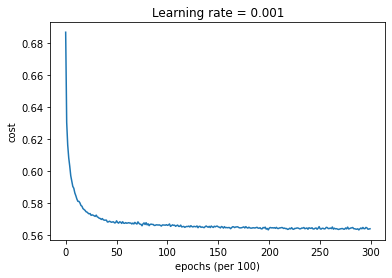

Accuracy: 0.7065173930427829


In [ ]:
# Mini-batch with Adam
# train 3-layer model
layers_dims = [train_X.shape[0], 18, 12, 1]
parameters = model(train_X, train_Y, layers_dims, num_epochs = 30000, optimizer = "adam",
                   mini_batch_size = 64, learning_rate = 0.001, beta=0.92, epsilon = 1e-07)

# Predict
predictions = predict(train_X, train_Y, parameters)

In [ ]:
# Binary accuracy using tf.keras.metrics.BinaryAccuracy
accuracy = BinaryAccuracy()
accuracy.update_state(train_Y, predictions)
accuracy.result().numpy()

0.7065174

In [ ]:
test_set['hashtags']

0                              []
1                    [earthquake]
2                              []
3            [spokane, wildfires]
4                              []
                  ...            
3258                           []
3259                           []
3260                           []
3261                           []
3262    [cityofcalgary, yycstorm]
Name: hashtags, Length: 3263, dtype: object

### Fitting Test Set

In [ ]:
# Adding hashtag to tweets at test data
for i, hashtag in enumerate(test_set['hashtags']):
  for hashtag in test_set.loc[i, 'hashtags']:
    test_set.loc[i, 'text'].append(hashtag)

test_set

,id,keyword,location,text,hashtags
0,0,NaN,NaN,"[happened, terrible, car, crash]",[]
1,2,NaN,NaN,"[heard, different, city, stay, safe, everyon, ...",[earthquake]
2,3,NaN,NaN,"[forest, fire, spot, pond, goose, fleeing, acr...",[]
3,9,NaN,NaN,"[apocalypse, light, spokane, wildfires]","[spokane, wildfires]"
4,11,NaN,NaN,"[typhoon, soudelor, kill, china, taiwan]",[]
...,...,...,...,...,...
3258,10861,NaN,NaN,"[earthquake, safety, los, angeles, safety, fas...",[]
3259,10865,NaN,NaN,"[storm, ri, worse, last, hurricane, cityamp, 3...",[]
3260,10868,NaN,NaN,"[green, line, derailment, chicago]",[]
3261,10874,NaN,NaN,"[meg, issue, hazardous, weather, outlook, hwo]",[]


In [ ]:
# Sequentialize test dataset
test_sequences_matrix = sequentialize(test_set['text'], max_words = 10000,
                                      words_per_element = 23, enforce_words_per_element = True)

print(test_sequences_matrix.shape, test_sequences_matrix.dtype)
print(test_sequences_matrix[0, :])
print(test_sequences_matrix[0, :].shape)

Highest word token: 8742
(3263, 23) int32
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0 668 958  52  36]
(23,)


Maximum token count per tweet with 5000 words tokenization: 22 



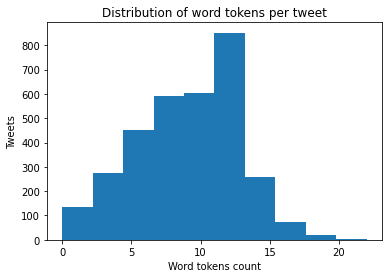

In [ ]:
# Analyzing word counts after tokenizing into matrices
word_counts = []
for i in range(0, test_sequences_matrix.shape[0]):
  word_counts.append(np.count_nonzero(test_sequences_matrix[i, :]))

print(f'Maximum token count per tweet with {max_words} words tokenization:', max(word_counts), '\n')

plt.hist(word_counts)
plt.title('Distribution of word tokens per tweet')
plt.xlabel('Word tokens count')
plt.ylabel('Tweets');

In [ ]:
# Defining test_X vector
test_X = (test_sequences_matrix/highest_word_token).T # Transpose of scaled test_sequences_matrix with shape (x_i, m)

print('First element on test set: ', test_X[:, 0], '\n')
print('Training set test_X shape: ', test_X.shape)

First element on test set:  [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.07641272 0.10958591 0.0059483  0.00411805] 

Training set test_X shape:  (23, 3263)


In [ ]:
# Fitting test data
test_predictions = predict(test_X, y = np.zeros(shape = (1, test_X.shape[1])), parameters = parameters)
# Predictions not accurate, comparing to a np.zeros matrix to fit test data

Accuracy: 0.6610481152313822


In [ ]:
test_predictions[0].shape

(3263,)

In [ ]:
# Creating submission dataset
submission = pd.read_csv('data/sample_submission.csv')
submission['target'] = test_predictions[0]
submission

,id,target
0,0,0
1,2,1
2,3,0
3,9,0
4,11,0
...,...,...
3258,10861,0
3259,10865,0
3260,10868,0
3261,10874,1


In [ ]:
submission.to_csv('data/submission.csv', index = False, header = True)